In [42]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Training Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip

In [1]:
!wget http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_train.tar.gz

--2022-11-30 18:29:56--  http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_train.tar.gz
Resolving www.zemris.fer.hr (www.zemris.fer.hr)... 31.147.204.179
Connecting to www.zemris.fer.hr (www.zemris.fer.hr)|31.147.204.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46907822 (45M) [application/x-gzip]
Saving to: ‘rmastif_train.tar.gz’

rmastif_train.tar.g 100%[===================>]  44.73M  16.2MB/s    in 2.8s    

2022-11-30 18:29:59 (16.2 MB/s) - ‘rmastif_train.tar.gz’ saved [46907822/46907822]



Test Dataset: https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip

In [14]:
!wget http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_test.tar.gz

--2022-11-30 18:53:31--  http://www.zemris.fer.hr/~kalfa/Datasets/rMASTIF/rmastif_test.tar.gz
Resolving www.zemris.fer.hr (www.zemris.fer.hr)... 31.147.204.179
Connecting to www.zemris.fer.hr (www.zemris.fer.hr)|31.147.204.179|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21169167 (20M) [application/x-gzip]
Saving to: ‘rmastif_test.tar.gz’

rmastif_test.tar.gz 100%[===================>]  20.19M  11.3MB/s    in 1.8s    

2022-11-30 18:53:34 (11.3 MB/s) - ‘rmastif_test.tar.gz’ saved [21169167/21169167]



In [16]:
!tar -xvf /content/rmastif_test.tar.gz -C /content/Testing

00000/
00000/00004_00000.ppm
00000/00006_00000.ppm
00000/00005_00001.ppm
00000/00002_00002.ppm
00000/00008_00003.ppm
00000/00004_00002.ppm
00000/00008_00001.ppm
00000/00009_00001.ppm
00000/00002_00003.ppm
00000/00003_00003.ppm
00000/00003_00000.ppm
00000/00009_00002.ppm
00000/00001_00002.ppm
00000/00005_00000.ppm
00000/00006_00002.ppm
00000/00000_00001.ppm
00000/00005_00003.ppm
00000/00009_00003.ppm
00000/00007_00001.ppm
00000/00007_00002.ppm
00000/00008_00000.ppm
00000/00000.csv
00000/00001_00001.ppm
00000/00001_00003.ppm
00000/00001_00000.ppm
00000/00008_00002.ppm
00000/00002_00001.ppm
00000/00004_00001.ppm
00000/00007_00000.ppm
00000/00000_00003.ppm
00000/00004_00003.ppm
00000/00007_00003.ppm
00000/00000_00000.ppm
00000/00005_00002.ppm
00000/00002_00000.ppm
00000/00003_00002.ppm
00000/00003_00001.ppm
00000/00009_00000.ppm
00000/00006_00003.ppm
00000/00006_00001.ppm
00000/00000_00002.ppm
00001/
00001/00004_00000.ppm
00001/00006_00000.ppm
00001/00005_00001.ppm
00001/00002_00002.ppm
00

Traindata & TestData Variables

In [ ]:
!rm -rf /content/Testing/00052

In [43]:
import torchvision
test_path = '/content/Testing'
train_path = '/content/Training'

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


data = torchvision.datasets.ImageFolder(root=train_path, transform=preprocess)

#train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,  num_workers=0)

train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])


#train_data = torchvision.datasets.ImageFolder(root=train_path,transform=preprocess)
train_dataLoader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True,  num_workers=0)
print('Train',len(train_dataset))

test_data = torchvision.datasets.ImageFolder(root=test_path,transform=preprocess)
#print('TEST',len(test_dataset))
print('TEST',len(test_data))
#test_dataLoader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True,  num_workers=0)
test_dataLoader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True,  num_workers=0)


Train 3235
TEST 1784


Hyper Parameters

In [44]:
num_classes = 31
num_epochs = 70
batch_size = 128
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    model.cuda()

cuda


In [45]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [46]:
import time
start_time = time.time()
total_step = len(train_dataLoader)
accuracy_list = []

steps_list = []
train_loss = []
train_accuracy = []
train_loss = []

for epoch in range(num_epochs):
  for i, data in enumerate(train_dataLoader):
    images, labels = data[0].to(device), data[1].to(device)

    #Forward Pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    #Backpropogation and Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #Train Accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,1)

    correct = (predicted == labels).sum().item()
    
    steps = i + 1
    accuracy = (correct / total) * 100
    accuracy_list.append(accuracy)
    steps_list.append(steps)
    train_loss.append(loss.item())
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
          .format(epoch + 1, num_epochs, steps, total_step, loss.item(),
          accuracy))
    
    

print("######## Training Finished in {} seconds ###########".format(time.time()-start_time))
print("Accuracy List: ",accuracy_list, "Steps List: ",steps_list)

Epoch [1/70], Step [1/26], Loss: 6.9086, Accuracy: 0.00%
Epoch [1/70], Step [2/26], Loss: 4.3356, Accuracy: 4.69%
Epoch [1/70], Step [3/26], Loss: 6.7122, Accuracy: 5.47%
Epoch [1/70], Step [4/26], Loss: 6.3782, Accuracy: 3.91%
Epoch [1/70], Step [5/26], Loss: 4.9984, Accuracy: 8.59%
Epoch [1/70], Step [6/26], Loss: 11.9386, Accuracy: 7.03%
Epoch [1/70], Step [7/26], Loss: 4.8706, Accuracy: 5.47%
Epoch [1/70], Step [8/26], Loss: 5.0271, Accuracy: 3.12%
Epoch [1/70], Step [9/26], Loss: 5.1681, Accuracy: 6.25%
Epoch [1/70], Step [10/26], Loss: 4.9998, Accuracy: 6.25%
Epoch [1/70], Step [11/26], Loss: 4.5247, Accuracy: 4.69%
Epoch [1/70], Step [12/26], Loss: 4.3456, Accuracy: 4.69%
Epoch [1/70], Step [13/26], Loss: 4.3524, Accuracy: 1.56%
Epoch [1/70], Step [14/26], Loss: 4.0021, Accuracy: 2.34%
Epoch [1/70], Step [15/26], Loss: 3.9814, Accuracy: 3.12%
Epoch [1/70], Step [16/26], Loss: 3.7468, Accuracy: 3.12%
Epoch [1/70], Step [17/26], Loss: 3.7129, Accuracy: 5.47%
Epoch [1/70], Step [18

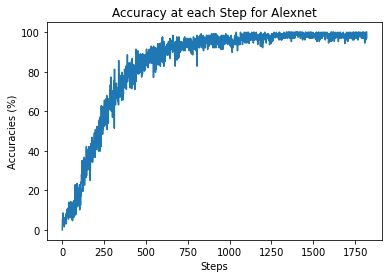

In [47]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Accuracy at each Step for Alexnet")
pyplot.xlabel("Steps")
pyplot.ylabel("Accuracies (%)")
pyplot.plot(accuracy_list)

pyplot.show()

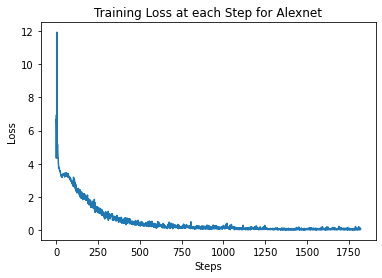

In [48]:
import matplotlib.pyplot as pyplot
import numpy as np

x_axis = np.array(steps_list)
y_axis = np.array(accuracy_list)

pyplot.title("Training Loss at each Step for Alexnet")
pyplot.xlabel("Steps")
pyplot.ylabel("Loss")
pyplot.plot(train_loss)

pyplot.show()

In [49]:
from torch.autograd import Variable
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
import torch.nn.functional as F

def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

In [50]:
for epoch in range(num_epochs):
  evaluate(test_dataLoader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Validation loss: 0.57819	Accuracy: 89.96636962890625 %

Average Validation loss: 0.60561	Accuracy: 89.91031646728516 %

Average Validation loss: 0.59470	Accuracy: 90.41480255126953 %

Average Validation loss: 0.61257	Accuracy: 89.79821014404297 %

Average Validation loss: 0.61003	Accuracy: 89.85426330566406 %

Average Validation loss: 0.59167	Accuracy: 89.85426330566406 %

Average Validation loss: 0.60401	Accuracy: 89.12556457519531 %

Average Validation loss: 0.60870	Accuracy: 89.79821014404297 %

Average Validation loss: 0.65165	Accuracy: 88.78924560546875 %

Average Validation loss: 0.64861	Accuracy: 89.1816177368164 %

Average Validation loss: 0.64599	Accuracy: 89.91031646728516 %

Average Validation loss: 0.63213	Accuracy: 89.4618911743164 %

Average Validation loss: 0.65813	Accuracy: 89.06951141357422 %

Average Validation loss: 0.65261	Accuracy: 89.5739974975586 %

Average Validation loss: 0.58827	Accuracy: 89.34977722167969 %

Average Validation loss: 0.63423	Accuracy:

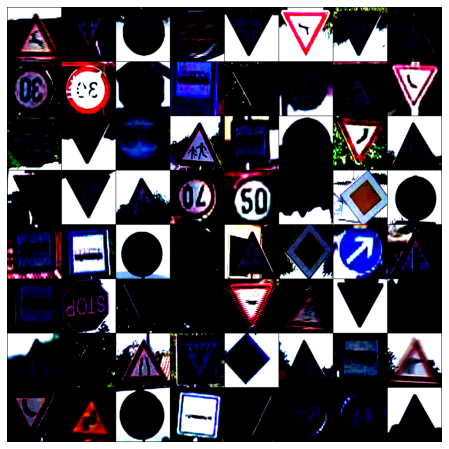

In [27]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, _ in test_dataLoader:
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break

In [ ]:
PATH = '/content/BTSD_Alx'
torch.save(model.state_dict(), PATH)